# Example 01 - Maximize C_l / C_d
- pyfoil: https://github.com/nathanrooy/aerodynamic-shape-optimization
- simulated annealing: https://github.com/nathanrooy/simulated-annealing

In [1]:
from scipy.optimize import minimize
from simulated_annealing import sa
from matplotlib import pyplot as plt

from pyfoil.parametric_airfoil import *
from pyfoil.xfoil import *

In [2]:
# lets read in the naca0012 airfoil geometry
target_airfoil = []
with open('naca0012.txt','r') as foil_txt:
    for i, row in enumerate(foil_txt.readlines()):
        if len(row.split())==2: 
            x, y = row.split()
            target_airfoil.append([float(x), float(y)])    
            
target_airfoil = np.asarray(target_airfoil)

In [3]:
# reverse fit the parametric airfoil to the naca0012
xpts = np.linspace(0,0.99,100)
initial_airfoil = [0.03, 0.76, 0.08, 0.48, 0.13, 0.15, 0.12, 0.15, -0.08, 0.37, -0.01, 0.69, 0.04]

In [4]:
# create cost function
def shape_match(control_pts, xpts=xpts, ta=target_airfoil):
    ca = np.array(bezier_airfoil(xpts, munge_ctlpts(control_pts, 3, 3)))
    try:
        return 1000 * np.sum(abs(ca[:,0] - ta[:,0]) + abs(ca[:,1] - ta[:,1]))
    except:
        return 1e10

In [5]:
# minimize this thing
res = minimize(shape_match, initial_airfoil, method='L-BFGS-B', tol=1e-10, options={'disp': True, 'maxiter':10000})

In [6]:
res.fun

np.float64(12.515550157584439)

In [7]:
res.x

array([ 0.02486637,  0.81492863,  0.02714863,  0.42259231,  0.06089415,
        0.15011154,  0.0589904 ,  0.14205392, -0.05733165,  0.38076424,
       -0.06204072,  0.74636812, -0.03519086])

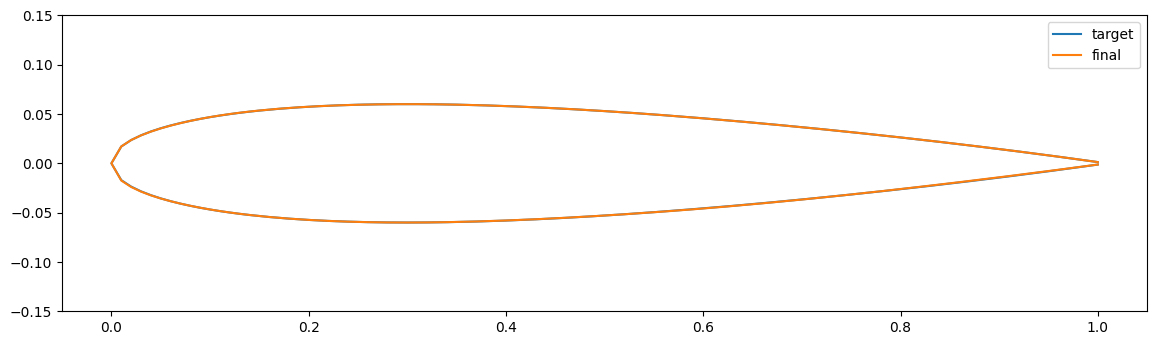

In [8]:
# lets plot the solution

matched_airfoil = np.array(bezier_airfoil(xpts, munge_ctlpts(res.x, 3, 3)))
x0, y0 = zip(*target_airfoil)
x1, y1 = zip(*matched_airfoil)

fig, ax = plt.subplots(figsize=(14,5))
plt.plot(x0, y0, label='target')
plt.plot(x1, y1, label='final')

ax.set_aspect('equal')
plt.ylim(-0.15,0.15)
plt.legend()
plt.show()

In [9]:
# the initial airfoil used panels with constant spacing
# lets be smart and change this to cosine spacing
# while using the control points we just solved for.

num_panels = 60
num_pts = num_panels + 1

x_rad = np.linspace(0, pi, num_pts)
x_cos = (np.cos(x_rad) / 2) + 0.5
x_cos = x_cos[1:]

# matched airfoil with cosine spacing
initial_airfoil = np.array(bezier_airfoil(x_cos, munge_ctlpts(res.x, 3, 3)))

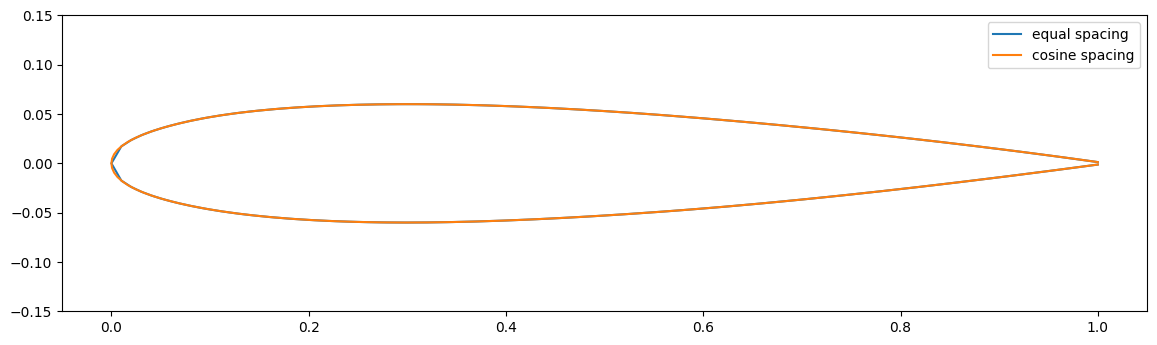

In [10]:
# final sanity check

x0, y0 = zip(*matched_airfoil)
x1, y1 = zip(*initial_airfoil)

fig, ax = plt.subplots(figsize=(14,5))
plt.plot(x0, y0, label='equal spacing')
plt.plot(x1, y1, label='cosine spacing')

ax.set_aspect('equal')
plt.ylim(-0.15,0.15)
plt.legend()
plt.show()

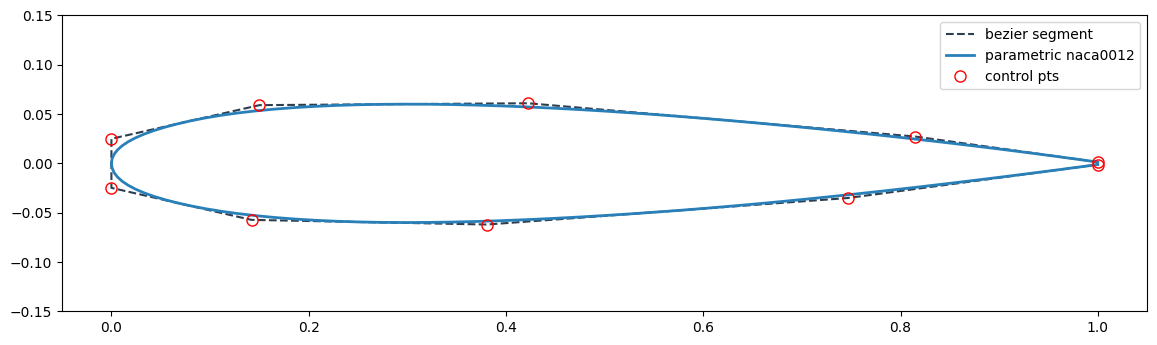

In [11]:
# plot final airfoil with control points
x0, y0=zip(*np.array(munge_ctlpts(res.x, 3, 3)))
x1, y1 = zip(*initial_airfoil)


fig, ax = plt.subplots(figsize=(14,5))
plt.plot(x0, y0, color='#2c3e50', linewidth=1.5, linestyle='--', label='bezier segment')
plt.plot(x1, y1, color='#2980b9', label='parametric naca0012', linewidth=2)
plt.plot(x0, y0, 'o', mfc='none', mec='r', markersize=8, label='control pts')

ax.set_aspect('equal')
plt.ylim(-0.15, 0.15)
plt.legend()

plt.show()

In [12]:
def cost_function(x, x_coords=x_cos):
    airfoil_file = 'airfoil.txt'
    
    try:
        # munge x-vector into bezier format
        control_pts = munge_ctlpts(x, 3, 3)

        # generate new airfoil
        curve = bezier_airfoil(x_coords, control_pts)

        # output airfoil to csv
        with open(airfoil_file,'w') as out_file:
            out_file.write('x,y\n')
            for item in curve:
                out_file.write(f'{item[0]},{item[1]}\n')

        # run xfoil and collect results
        results_dict = run_xfoil()
        
        # determine cost
        cost = results_dict['cl'] / results_dict['cd']
        if results_dict['cl'] < 0: cost = 0.01
        
    except:
        cost = 0.01
    
    # remove airfoil file
    os.system(f'rm -rf {airfoil_file}')

    print(f'> cl/cd={cost:0.4f} -> cost_func={1000.0 / cost:0.4f}')
    
    return 1000.0 / cost

In [13]:
opt = sa.minimize(cost_function, res.x, opt_mode = 'continuous', step_max=500, t_max=2.5, t_min=0, damping=0.01) 

> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.3166 -> cost_func=3158.8235
> cl/cd=0.31

In [14]:
opt.results()

+------------------------ RESULTS -------------------------+

      opt.mode: continuous
cooling sched.: linear additive cooling
       damping: 0.01

  initial temp: 2.5
    final temp: 0.005000
     max steps: 500
    final step: 500

  final energy: 3158.823529

+-------------------------- END ---------------------------+


In [15]:
# initial
# note that the initial airfoil did produce just the smallest bit of lift 
# which is why the cost function is greater than zero...
cost_function(opt.x0)

> cl/cd=0.3166 -> cost_func=3158.8235


3158.823529411765

In [16]:
# final
cost_function(opt.best_state)

> cl/cd=0.3166 -> cost_func=3158.8235


3158.823529411765

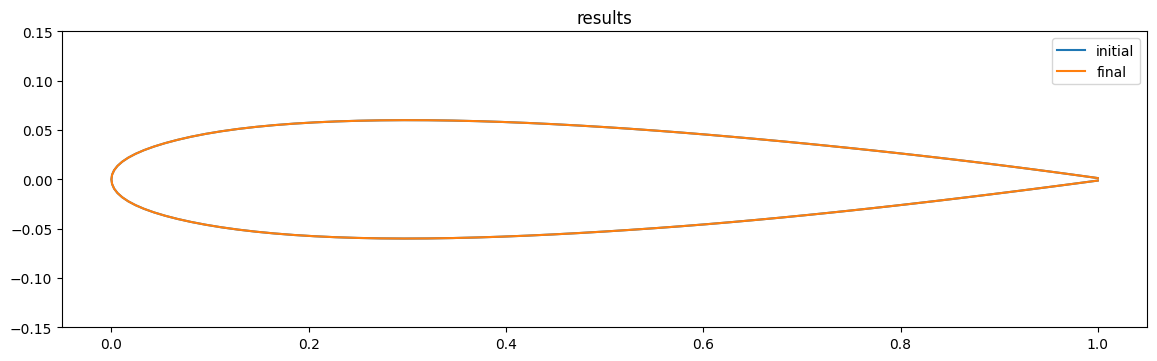

In [17]:
airfoil_initial = bezier_airfoil(x_cos, munge_ctlpts(opt.x0, 3, 3))
airfoil_final   = bezier_airfoil(x_cos, munge_ctlpts(opt.best_state, 3, 3))

fig, ax = plt.subplots(figsize=(14,5))

x_initial, y_initial=zip(*airfoil_initial)
x_final, y_final=zip(*airfoil_final)

plt.plot(x_initial, y_initial, label='initial')
plt.plot(x_final, y_final, label='final')
plt.title('results')

plt.legend()
plt.ylim(-0.15, 0.15)
ax.set_aspect('equal')
plt.show()